In [1]:
import pandas as pd
import numpy as np

# Для работы с матрицами
from scipy.sparse import csr_matrix
 
# Модель второго уровня
from lightgbm import LGBMClassifier

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import ItemItemRecommender  # нужен для одного трюка
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from datetime import datetime, date, time, timedelta

In [4]:
import pickle

In [5]:
from src.metrics import money_precision_at_k,  recall_at_k
from src.utils import prefilter_items, postfilter_items, popularity_recommendation
from src.recommenders import MainRecommender
from src.feature import new_item_features, new_user_features, time_features

## Бизнес ограничения в топ-5 товарах:

Для каждого юзера 5 рекомендаций (иногда модели могут возвращать < 5)

2 новых товара (юзер никогда не покупал)

1 дорогой товар, > 7 долларов (price = sum(sales_value) / sum(quantity))

Все товары из разных категорий (категория - sub_commodity_desc)

Стоимость каждого рекомендованного товара > 1 доллара (price = sum(sales_value) / sum(quantity))

Вам нужно добавить обработку холодных юзеров (рекомендовать им топ-5 популярных товаров)

In [6]:
path = 'C:/Users/user/Documents/mydocs/rs_geek_brains/final_project/data/'
data = pd.read_csv(path + 'retail_train.csv')
user_features = pd.read_csv(path + 'hh_demographic.csv')
item_features = pd.read_csv(path +  'product.csv')

In [7]:
pre_N = 2700 #количество топ популярных на отборе item_id 
top_N = 50 #количество топ плюх для рекомендаций второй модели

In [8]:
data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)

In [9]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

In [10]:
data.week_no.nunique()

95

In [11]:
user_features.head(3)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8


In [12]:
item_features.head(3)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,


In [13]:
data.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [14]:
data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))

## Двухуровневая модель 

### Подготовка выборки для моделей

Так как у нас две модели, то для каждой из них мы делаем свою обучающую и тестовую выборку. Поэтому разбиваем наш датасет на три части.

### МОДЕЛЬ 1 (отбор кандидитов топ 200):

-- давние покупки до 9 недель - обучение и предсказание топ 200 

-- покупки за последние 9 минус 3 недели последние - тест или валидация (купил или не купил) 

-- способ валидации - recall

итого, модель 1 уровня делает предсказание на период 6 недель.

### МОДЕЛЬ 2 (ранжирование топ 5 или 10 финальных рекомендаций):

-- результаты предсказаний из модели 1 на 6 недель - обучение

-- покупки за последние 3 недели - тест 

-- способ валидации - precision

Цель - избежать переобучения и не обучать две модели на одних и тех же данных.

In [15]:
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

#модель 1 -  давние покупки до 6 недель
data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]

#модель 1 - покупки с 9 до 3-й недели - итого 6 
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

In [16]:
data_train_lvl_1.week_no.nunique()

85

In [17]:
data_val_lvl_1.week_no.unique()

array([86, 87, 88, 89, 90, 91], dtype=int64)

In [18]:
#модель 2 - берем уникальных пользователей для тренировки на основе модель 1 (за 6 недель)
data_train_lvl_2 = data_val_lvl_1.copy()  

#модель 2 - берем уникальных пользователей для валидации или теста модели 2 за последние 3 недели
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

In [19]:
data_val_lvl_2.week_no.unique()

array([92, 93, 94, 95], dtype=int64)

In [20]:
data_val_lvl_2.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,price
2277416,338,41260573635,636,840173,1,1.99,369,0.0,112,92,0.0,0.0,1.99
2277417,338,41260573635,636,1037348,1,0.89,369,-0.3,112,92,0.0,0.0,0.89
2277418,338,41260573635,636,5592737,2,1.58,369,-0.2,112,92,0.0,0.0,0.79
2277419,338,41260573635,636,7441679,1,3.69,369,0.0,112,92,0.0,0.0,3.69
2277420,338,41260573635,636,7442317,1,2.69,369,0.0,112,92,0.0,0.0,2.69


In [21]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features, take_n_popular=pre_N)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 2701


## Обучаем модель 1-го уровня для получения рекомендации топ 200

In [22]:
recommender = MainRecommender(data_train_lvl_1)

In [23]:
result_exist1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_exist1.rename(columns={'item_id': 'actual'}, inplace=True)
#result_exist = result_exist.merge(users_lvl_2, on='user_id', how='left')
train_users1 = data_train_lvl_1['user_id'].unique()
result_exist1 = result_exist1.loc[result_exist1['user_id'].isin(train_users1)]
result_exist1.head()

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96..."
4,7,"[836281, 843306, 845294, 914190, 920456, 93886..."


In [24]:
result_exist1['own'] = result_exist1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=top_N))

In [25]:
result_exist1.head()

,user_id,actual,own
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[856942, 5577022, 9655212, 931136, 8090541, 82..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[1076580, 911974, 1075368, 820301, 898847, 904..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67...","[910109, 887003, 1121367, 951821, 1115098, 108..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[13003092, 9911484, 1108094, 8203834, 1048257,..."
4,7,"[836281, 843306, 845294, 914190, 920456, 93886...","[840386, 6602729, 1122358, 1070803, 894360, 10..."


In [26]:
result_exist1.apply(lambda row: recall_at_k (row['own'], row['actual'], k=top_N), axis=1).mean()

0.08889530462911167

In [27]:
##

## Готовим X_train, y_train

In [28]:
new2 = prefilter_items(data_val_lvl_2, item_features, take_n_popular=pre_N)

In [29]:
recommender2 = MainRecommender(new2)

In [30]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

In [31]:
users_lvl_2.head()

,user_id
0,2070
1,2021
2,1753
3,2120
4,1346


In [32]:
# Пока только warm start - TODO - если нет юзера 
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=top_N))

In [33]:
users_lvl_2.head()

,user_id,candidates
0,2070,"[834103, 917033, 1119399, 1107824, 1016800, 10..."
1,2021,"[1119454, 835578, 1013928, 1038462, 6534077, 9..."
2,1753,"[1089066, 862981, 901543, 963686, 879755, 9213..."
3,2120,"[1106523, 951590, 5569230, 916122, 1126899, 10..."
4,1346,"[5574377, 903738, 8090560, 1122115, 912004, 10..."


In [34]:
#новые пользователи, которых не было в data_train_lvl_1
train_users_new = [x for x in data_train_lvl_2['user_id'].unique() if x not in data_train_lvl_1['user_id'].unique()]

In [35]:
train_users_new

[1984, 296]

In [36]:
users_lvl_2_new = pd.DataFrame (train_users_new, columns = ['user_id']) #data_train_lvl_2[data_train_lvl_2['user_id'].isin(train_users_new)]

In [37]:
users_lvl_2_new['candidates'] = users_lvl_2_new['user_id'].apply(lambda x: recommender._extend_with_top_popular([], N=top_N))

In [38]:
users_lvl_2_new

,user_id,candidates
0,1984,"[1106523, 951590, 5569230, 916122, 1126899, 10..."
1,296,"[1106523, 951590, 5569230, 916122, 1126899, 10..."


In [39]:
##объединяем текущих и новых пользователей

In [40]:
users_lvl_2 = users_lvl_2.append(users_lvl_2_new)

In [41]:
#проверка нового пользователя
users_lvl_2.loc[users_lvl_2['user_id'] == 1813]

,user_id,candidates
724,1813,"[987724, 1106523, 951590, 5569230, 916122, 112..."


In [42]:
#аналог Array Join из sql 
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)

In [43]:
s.name = 'item_id'
users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
users_lvl_2['drop'] = 1  # фиктивная переменная
users_lvl_2.head(4)

,user_id,item_id,drop
0,2070,834103,1
0,2070,917033,1
0,2070,1119399,1
0,2070,1107824,1


In [44]:
users_lvl_2.shape[0]

107900

In [45]:
data_train_lvl_2.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,price
2104867,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0,1.00
2107468,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0,0.99
2107469,2021,40618753059,594,856060,1,1.77,443,-0.09,101,86,0.0,0.0,1.77
2107470,2021,40618753059,594,869344,1,1.67,443,-0.22,101,86,0.0,0.0,1.67
2107471,2021,40618753059,594,896862,2,5.00,443,-2.98,101,86,0.0,0.0,2.50


In [46]:
# проставим таргет (покупал или нет юзер в товары кандидаты в период 6 недель)
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

#сливаем так, что в результате видим, где покупки совпадают, там 1, а где нет, то Nan 
targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

#заполняем nan нулями 
targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2.drop('drop', axis=1, inplace=True)

In [47]:
targets_lvl_2.head()

,user_id,item_id,target
0,2070,834103,1.0
1,2070,834103,1.0
2,2070,834103,1.0
3,2070,834103,1.0
4,2070,834103,1.0


In [48]:
targets_lvl_2['target'].mean()

0.15668751861781352

## FEATURE ENGINEERING

In [49]:
user_features = new_user_features(data_train_lvl_1, user_features, recommender.users_emb_df)

In [50]:
user_features.head()

,marital_status_code,homeowner_desc,hh_comp_desc,household_size_desc,user_id,0,1,2,3,4,...,mean_time,age,income,kids,average_basket,sum_per_week,night_time,morning_time,day_time,evening_time
0,A,Homeowner,2 Adults No Kids,2,1,-6.116711,-18.525061,-1.225579,-5.767150,-0.117973,...,1397.157837,70,45,0,2.565924,32.330647,0.0,0.281979,0.596639,0.121382
1,A,Homeowner,2 Adults No Kids,2,7,-0.205966,4.609637,4.490599,6.549904,-4.211341,...,1695.072388,50,70,0,3.053466,20.332490,0.0,0.000000,0.528269,0.471731
2,U,Unknown,2 Adults Kids,3,8,-5.291779,8.123002,-0.201657,-1.285189,1.779806,...,1633.452393,30,30,1,3.022873,33.642794,0.0,0.192389,0.304440,0.503171
3,U,Homeowner,2 Adults Kids,4,13,11.193302,2.768559,-1.791017,5.228184,-3.750573,...,1607.527588,30,95,2,3.241908,46.340216,0.0,0.172840,0.246091,0.581070
4,B,Homeowner,Single Female,1,16,-2.726591,-1.148597,0.509945,0.381638,0.255324,...,1375.000000,50,70,0,1.997187,0.375941,0.0,0.312500,0.562500,0.125000


In [51]:
item_features = new_item_features(data_train_lvl_1, item_features, recommender.items_emb_df)

In [52]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2.head(3)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,0,...,26,27,28,29,coupon_disc,quantity_of_sales,exp_sales_0_1,exp_sales_0_01,exp_sales_0_05,sales_mean
0,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,0.010293,...,-0.001124,0.002615,0.009931,-0.011792,0.0,363,7.33272,4.132002,6.799658,6.7725
1,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,0.010293,...,-0.001124,0.002615,0.009931,-0.011792,0.0,363,7.33272,4.132002,6.799658,6.7725
2,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,0.010293,...,-0.001124,0.002615,0.009931,-0.011792,0.0,363,7.33272,4.132002,6.799658,6.7725


In [53]:
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')
targets_lvl_2.head(3)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,0_x,...,mean_time,age,income,kids,average_basket,sum_per_week,night_time,morning_time,day_time,evening_time
0,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,0.010293,...,1518.882446,50.0,70.0,0.0,2.800278,33.076225,0.175299,0.071713,0.161355,0.591633
1,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,0.010293,...,1518.882446,50.0,70.0,0.0,2.800278,33.076225,0.175299,0.071713,0.161355,0.591633
2,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,0.010293,...,1518.882446,50.0,70.0,0.0,2.800278,33.076225,0.175299,0.071713,0.161355,0.591633


In [54]:
targets_lvl_2.columns

Index(['user_id', 'item_id', 'target', 'manufacturer', 'department', 'brand',
       'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product', '0_x',
       '1_x', '2_x', '3_x', '4_x', '5_x', '6_x', '7_x', '8_x', '9_x', '10_x',
       '11_x', '12_x', '13_x', '14_x', '15_x', '16_x', '17_x', '18_x', '19_x',
       '20_x', '21_x', '22_x', '23_x', '24_x', '25_x', '26_x', '27_x', '28_x',
       '29_x', 'coupon_disc', 'quantity_of_sales', 'exp_sales_0_1',
       'exp_sales_0_01', 'exp_sales_0_05', 'sales_mean', 'marital_status_code',
       'homeowner_desc', 'hh_comp_desc', 'household_size_desc', '0_y', '1_y',
       '2_y', '3_y', '4_y', '5_y', '6_y', '7_y', '8_y', '9_y', '10_y', '11_y',
       '12_y', '13_y', '14_y', '15_y', '16_y', '17_y', '18_y', '19_y', '20_y',
       '21_y', '22_y', '23_y', '24_y', '25_y', '26_y', '27_y', '28_y', '29_y',
       'mean_time', 'age', 'income', 'kids', 'average_basket', 'sum_per_week',
       'night_time', 'morning_time', 'day_time', 'evening_time'],


In [55]:
X_train = targets_lvl_2.drop('target', axis=1)

In [56]:
y_train = targets_lvl_2[['target']]

In [57]:
cat_feats_f = ['manufacturer', 'department', 'brand', 'commodity_desc',
       'sub_commodity_desc', 'curr_size_of_product', 
       'marital_status_code', 'homeowner_desc', 'hh_comp_desc',
       'household_size_desc']

In [58]:
weak_features = ['brand', 'department'] #['age', 'brand','department','kids', 'household_size_desc']

In [59]:
cat_feats_f = [x for x in cat_feats_f if x not in weak_features]

In [60]:
X_train =  X_train[[c for c in X_train.columns if c not in weak_features]]

In [61]:
#cat_feats = X_train.columns[2:].tolist()

In [62]:
X_train[cat_feats_f] = X_train[cat_feats_f].astype('category') #говорим, что все фичи категориальные 
cat_feats_f

['manufacturer',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'marital_status_code',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc']

In [63]:
X_train.head()

,user_id,item_id,manufacturer,commodity_desc,sub_commodity_desc,curr_size_of_product,0_x,1_x,2_x,3_x,...,mean_time,age,income,kids,average_basket,sum_per_week,night_time,morning_time,day_time,evening_time
0,2070,834103,2224,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,0.010293,0.008111,-0.003916,-0.001014,...,1518.882446,50.0,70.0,0.0,2.800278,33.076225,0.175299,0.071713,0.161355,0.591633
1,2070,834103,2224,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,0.010293,0.008111,-0.003916,-0.001014,...,1518.882446,50.0,70.0,0.0,2.800278,33.076225,0.175299,0.071713,0.161355,0.591633
2,2070,834103,2224,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,0.010293,0.008111,-0.003916,-0.001014,...,1518.882446,50.0,70.0,0.0,2.800278,33.076225,0.175299,0.071713,0.161355,0.591633
3,2070,834103,2224,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,0.010293,0.008111,-0.003916,-0.001014,...,1518.882446,50.0,70.0,0.0,2.800278,33.076225,0.175299,0.071713,0.161355,0.591633
4,2070,834103,2224,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,0.010293,0.008111,-0.003916,-0.001014,...,1518.882446,50.0,70.0,0.0,2.800278,33.076225,0.175299,0.071713,0.161355,0.591633


## Готовим X_test, y_test

In [64]:
users_val_lvl_2 = pd.DataFrame(data_val_lvl_2 ['user_id'].unique())
users_val_lvl_2.columns = ['user_id']

In [65]:
users_val_lvl_2.head()

,user_id
0,338
1,2120
2,2324
3,514
4,1762


In [66]:
users_val_lvl_2.user_id.nunique()

2042

In [67]:
#вставляем в dataframe train только тех пользователей, которые есть в последние 3 недели 
targets_lvl_2_test2 = X_train.loc[X_train['user_id'].isin(users_val_lvl_2.user_id.unique())]

In [68]:
targets_lvl_2_test2.head()

,user_id,item_id,manufacturer,commodity_desc,sub_commodity_desc,curr_size_of_product,0_x,1_x,2_x,3_x,...,mean_time,age,income,kids,average_basket,sum_per_week,night_time,morning_time,day_time,evening_time
0,2070,834103,2224,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,0.010293,0.008111,-0.003916,-0.001014,...,1518.882446,50.0,70.0,0.0,2.800278,33.076225,0.175299,0.071713,0.161355,0.591633
1,2070,834103,2224,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,0.010293,0.008111,-0.003916,-0.001014,...,1518.882446,50.0,70.0,0.0,2.800278,33.076225,0.175299,0.071713,0.161355,0.591633
2,2070,834103,2224,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,0.010293,0.008111,-0.003916,-0.001014,...,1518.882446,50.0,70.0,0.0,2.800278,33.076225,0.175299,0.071713,0.161355,0.591633
3,2070,834103,2224,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,0.010293,0.008111,-0.003916,-0.001014,...,1518.882446,50.0,70.0,0.0,2.800278,33.076225,0.175299,0.071713,0.161355,0.591633
4,2070,834103,2224,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,0.010293,0.008111,-0.003916,-0.001014,...,1518.882446,50.0,70.0,0.0,2.800278,33.076225,0.175299,0.071713,0.161355,0.591633


In [69]:
len(targets_lvl_2_test2.user_id.unique())

1916

In [70]:
#выделяем новых пользователей и делаем прогноз по популярности 

In [71]:
X_test_new_users = [x for x in users_val_lvl_2.user_id.unique() if x not in targets_lvl_2_test2.user_id.unique()]

In [72]:
X_test_new_users = pd.DataFrame (X_test_new_users, columns = ['user_id']) 

In [73]:
#X_test_new_users['candidates'] = X_test_new_users['user_id'].apply(lambda x: recommender._extend_with_top_popular([], N=top_N))

In [74]:
X_test_new_users['candidates'] = X_test_new_users['user_id'].apply(lambda x: recommender2.get_similar_items_recommendation(x, N=top_N))

In [75]:
#TODO - везде ли есть значения ? Если есть юзеры в data_train_lvl_1 то ок, если нет то использовать _get_similar_item(self, item_id):
X_test_new_users.head()

,user_id,candidates
0,1360,"[1136257, 847025, 1053690, 962229, 854852, 976..."
1,860,"[1053690, 962229, 854852, 976199, 986912, 1592..."
2,1851,"[943076, 840173, 999999, 1017325, 873654, 1053..."
3,899,"[1043494, 933835, 1053690, 962229, 854852, 976..."
4,1048,"[819978, 885023, 5566674, 848319, 839243, 9999..."


In [76]:
X_test = targets_lvl_2_test2.copy()

In [77]:
X_test[cat_feats_f] = X_test[cat_feats_f].astype('category') #говорим, что все фичи категориальные 

## Обучаем модель классификации LGBMClassifier

In [78]:
%%time

lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats_f)
lgb.fit(X_train, y_train)

C:\Users\user\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\anaconda3\lib\site-packages\lightgbm\basic.py:814: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Wall time: 2.03 s


LGBMClassifier(boosting_type='gbdt',
               categorical_column=['manufacturer', 'commodity_desc',
                                   'sub_commodity_desc', 'curr_size_of_product',
                                   'marital_status_code', 'homeowner_desc',
                                   'hh_comp_desc', 'household_size_desc'],
               class_weight=None, colsample_bytree=1.0, importance_type='split',
               learning_rate=0.1, max_depth=7, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=31, objective='binary', random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

## Feature importance

In [79]:
# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(lgb.feature_importances_,X_train.columns)), columns=['value','feature'])

In [80]:
X_train.columns

Index(['user_id', 'item_id', 'manufacturer', 'commodity_desc',
       'sub_commodity_desc', 'curr_size_of_product', '0_x', '1_x', '2_x',
       '3_x', '4_x', '5_x', '6_x', '7_x', '8_x', '9_x', '10_x', '11_x', '12_x',
       '13_x', '14_x', '15_x', '16_x', '17_x', '18_x', '19_x', '20_x', '21_x',
       '22_x', '23_x', '24_x', '25_x', '26_x', '27_x', '28_x', '29_x',
       'coupon_disc', 'quantity_of_sales', 'exp_sales_0_1', 'exp_sales_0_01',
       'exp_sales_0_05', 'sales_mean', 'marital_status_code', 'homeowner_desc',
       'hh_comp_desc', 'household_size_desc', '0_y', '1_y', '2_y', '3_y',
       '4_y', '5_y', '6_y', '7_y', '8_y', '9_y', '10_y', '11_y', '12_y',
       '13_y', '14_y', '15_y', '16_y', '17_y', '18_y', '19_y', '20_y', '21_y',
       '22_y', '23_y', '24_y', '25_y', '26_y', '27_y', '28_y', '29_y',
       'mean_time', 'age', 'income', 'kids', 'average_basket', 'sum_per_week',
       'night_time', 'morning_time', 'day_time', 'evening_time'],
      dtype='object')

In [81]:
feature_imp.to_excel('feature_importance_1.xlsx')

In [82]:
item_embedding_factors = [x for x in feature_imp.feature if '_x' in x]
user_embedding_factors = [x for x in feature_imp.feature if '_y' in x]
total_embed = user_embedding_factors + item_embedding_factors

In [83]:
item_emb_sum = 0
user_emb_sum = 0
for i, k in enumerate (feature_imp.feature):
    if k in item_embedding_factors:
        item_emb_sum += feature_imp.value.iloc[i]
    if k in user_embedding_factors:
        user_emb_sum += feature_imp.value.iloc[i]
    else:
        pass

In [84]:
dat= {'feature': ['item_embedding_feats', 'user_embedding_feats'], 'value': [item_emb_sum, user_emb_sum ]}
dat = pd.DataFrame.from_dict(dat)

In [85]:
feature_imp = feature_imp.loc[~feature_imp['feature'].isin(total_embed)]
feature_imp = feature_imp.append(dat)

In [86]:
feature_imp ['share'] = (feature_imp['value'] / feature_imp ['value'].sum()) * 100

In [87]:
feature_imp 

,value,feature,share
0,1,age,0.033333
1,1,household_size_desc,0.033333
2,1,kids,0.033333
3,2,hh_comp_desc,0.066667
4,2,homeowner_desc,0.066667
5,4,exp_sales_0_05,0.133333
6,5,marital_status_code,0.166667
7,7,coupon_disc,0.233333
9,9,income,0.300000
17,11,sales_mean,0.366667


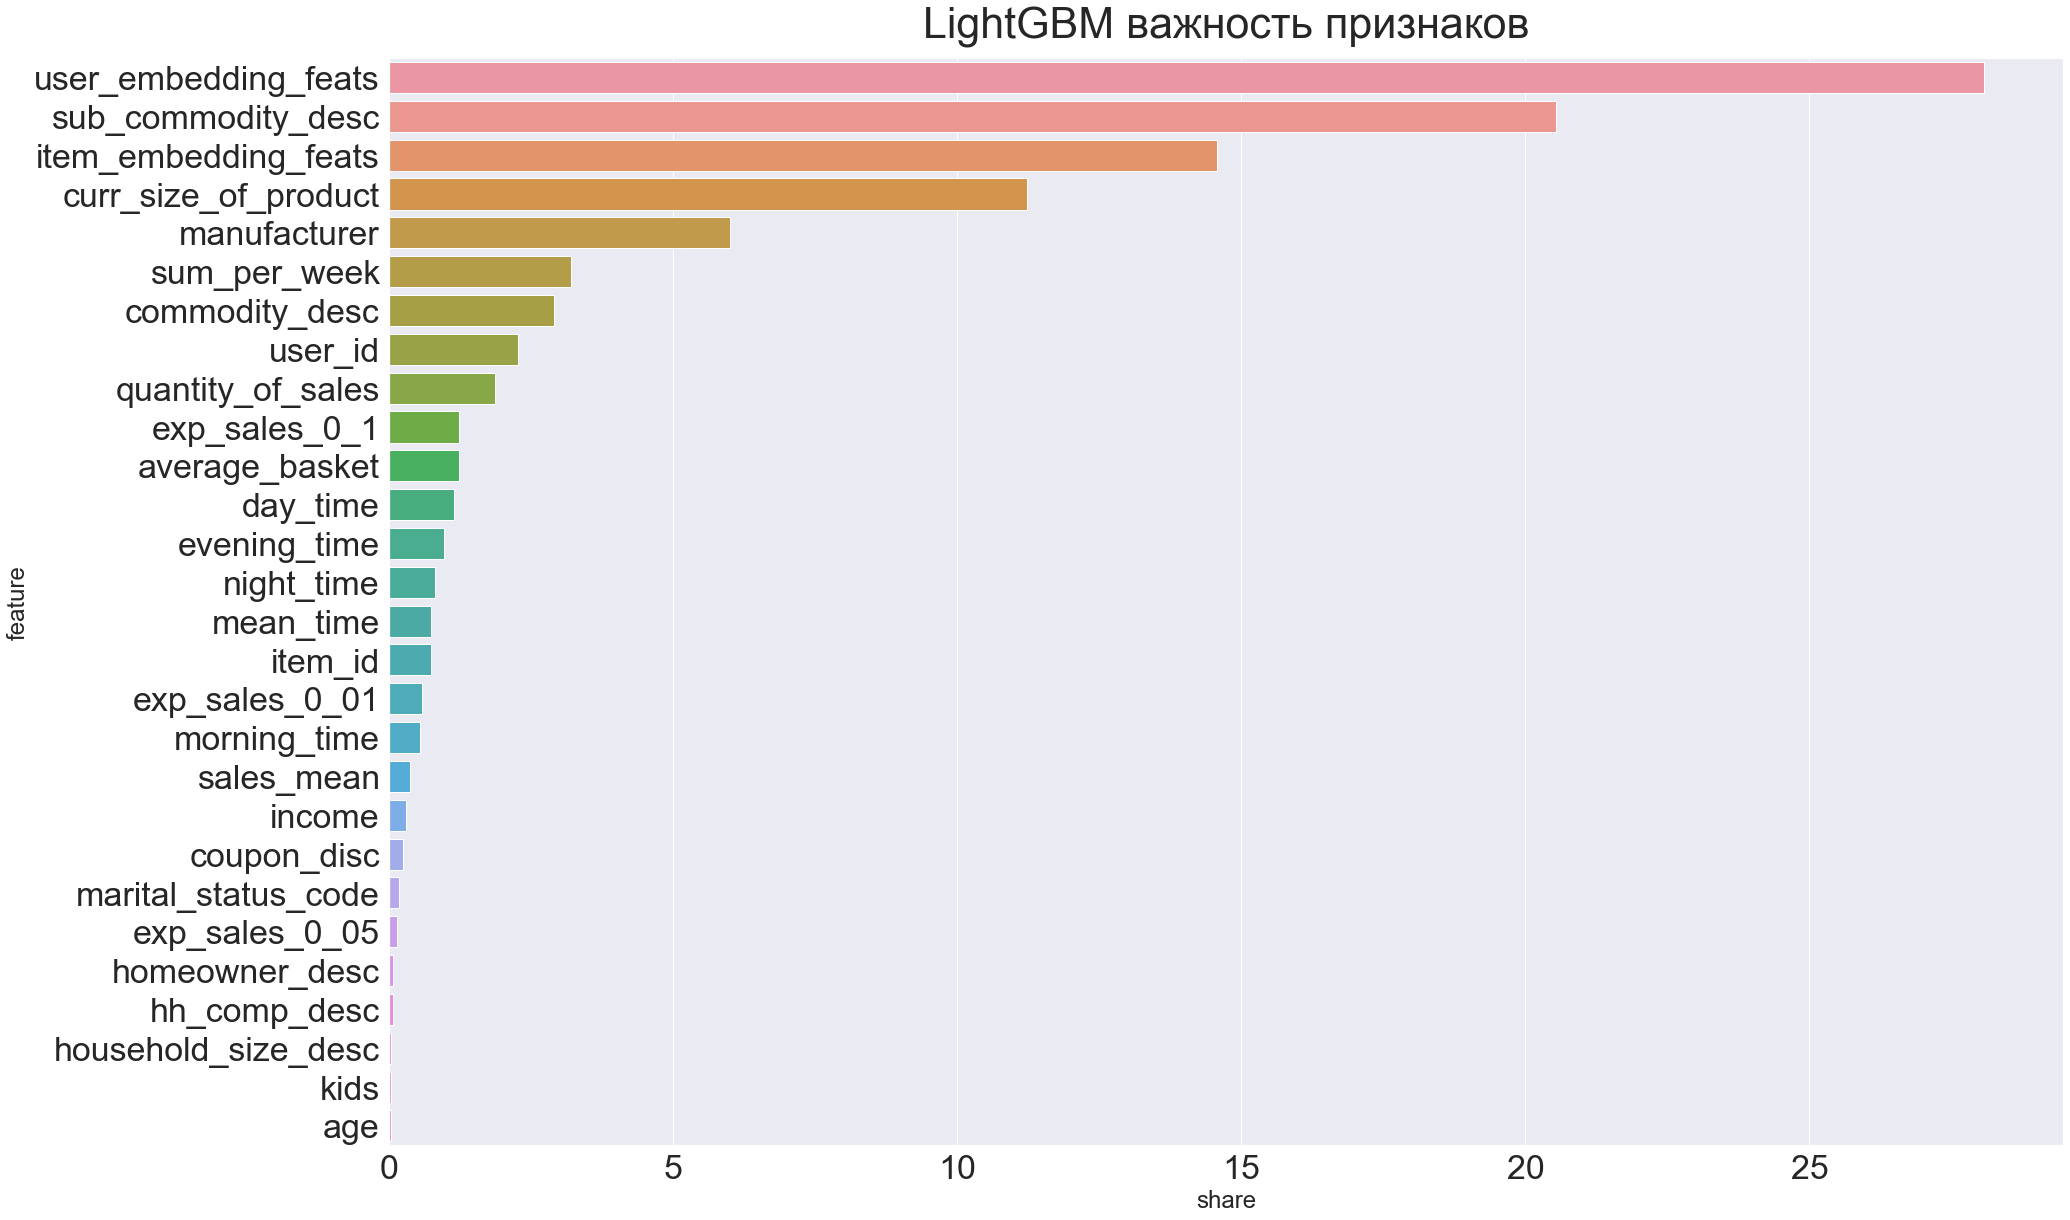

In [88]:
sns.set(font_scale=2) 
params = {'axes.titlesize':'43',
          'xtick.labelsize':'34',
          'ytick.labelsize':'34',
          'font.size': 22}
plt.rcParams.update(params)
plt.figure(figsize=(30, 20))
sns.barplot(x="share", y="feature", data=feature_imp.sort_values(by="share", ascending=False))
plt.title('LightGBM важность признаков', pad = 20)
plt.savefig('lgbm_importances-01.png', format='png')

## Forecast

In [89]:
#прогноз вероятности покупки на N позиций по каждому юзеру 
test_preds_proba = lgb.predict_proba(X_test)[:, 1]

In [90]:
len(test_preds_proba)

102111

In [91]:
X_test['predict_proba'] = test_preds_proba

In [92]:
#сортируем по вероятности, чтобы выбрать топ потом 
X_test.sort_values(['user_id', 'predict_proba'], ascending=False, inplace=True)

In [93]:
recs_lgb = X_test.groupby('user_id')['item_id']
recomendations_dict = []
for user, preds in recs_lgb:
    recomendations_dict.append({'user_id': user, 'candidates': preds.tolist()})
recomendations_df = pd.DataFrame(recomendations_dict)
recomendations_df.head()

,user_id,candidates
0,1,"[940947, 940947, 940947, 8293439, 8293439, 829..."
1,6,"[1098844, 1098844, 1119051, 1119051, 1119051, ..."
2,7,"[1122358, 840386, 849505, 968936, 963502, 1010..."
3,8,"[872137, 972931, 12302069, 983795, 5591154, 85..."
4,9,"[1056005, 1075470, 862799, 907647, 1070820, 11..."


In [94]:
#добавляем новых пользователей и их прогноз
recomendations_df = recomendations_df.append(X_test_new_users)

In [95]:
recomendations_df.head()

,user_id,candidates
0,1,"[940947, 940947, 940947, 8293439, 8293439, 829..."
1,6,"[1098844, 1098844, 1119051, 1119051, 1119051, ..."
2,7,"[1122358, 840386, 849505, 968936, 963502, 1010..."
3,8,"[872137, 972931, 12302069, 983795, 5591154, 85..."
4,9,"[1056005, 1075470, 862799, 907647, 1070820, 11..."


In [96]:
## Подготовим dataframe для пост фильтра для финальной оценки - все данные кроме последних 3=х недель 

In [97]:
test_size_weeks = 3
data_train_post = data[data['week_no'] < data['week_no'].max() - test_size_weeks]

In [98]:
# Определяем цену товара
data_train_post['price'] = data_train_post['sales_value'] / (np.maximum(data_train_post['quantity'], 1))
data_train_post.head()

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,price
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0,1.39
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0,0.82
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0,0.99
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0,1.21
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0,1.50


In [99]:
recomendations_df['lgb_recs_f_n']= recomendations_df['user_id'].apply(lambda user:\
                                                                    postfilter_items(recomendations_df['candidates'][recomendations_df['user_id'] ==user].tolist()[0], \
                                                                                     data_train_post, user, item_features, N=5))

In [100]:
recomendations_df.head()

,user_id,candidates,lgb_recs_f_n
0,1,"[940947, 940947, 940947, 8293439, 8293439, 829...","[6533765, 940947, 1075074, 10149640, 9655212]"
1,6,"[1098844, 1098844, 1119051, 1119051, 1119051, ...","[1048257, 1098844, 862349, 1037863, 1098284]"
2,7,"[1122358, 840386, 849505, 968936, 963502, 1010...","[974156, 1122358, 849505, 963502, 1079023]"
3,8,"[872137, 972931, 12302069, 983795, 5591154, 85...","[919766, 872137, 12302069, 5591154, 950824]"
4,9,"[1056005, 1075470, 862799, 907647, 1070820, 11...","[916122, 6533765, 918046, 1056005, 1070820]"


In [101]:
####

## Финальная оценка проекта 

In [102]:
result_exist2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()

In [103]:
#проверка что у нас есть все пользователи, включая новых. Правильный ответ 0
len([x for x in result_exist2.user_id.unique() if x not in recomendations_df.user_id.unique()])

0

In [104]:
result_exist2 = result_exist2.merge(recomendations_df[['user_id', 'lgb_recs_f_n']], on='user_id', how='left')

In [105]:
result_exist2.rename(columns={'item_id': 'actual'}, inplace=True)

In [106]:
 # dataframe  товар - цена = средняя цена на товар
item_price = data_train_post.groupby('item_id')['price'].mean().reset_index()

In [107]:
result_exist2.head()

,user_id,actual,lgb_recs_f_n
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[6533765, 940947, 1075074, 10149640, 9655212]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[13842090, 854852, 6533765, 1053690, 986912]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1048257, 1098844, 862349, 1037863, 1098284]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[974156, 1122358, 849505, 963502, 1079023]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[919766, 872137, 12302069, 5591154, 950824]"


In [108]:
result_exist2.apply(lambda row: money_precision_at_k (row['lgb_recs_f_n'], row['actual'], item_price, k=5), axis=1).mean()

0.10238858961802155

#previous - 0,071 без embedding, c embedding - 0.07340039324389298  + возраст и доход 0.071766 
#+ Средний чек - 0.07346540709496363 -- 0.07428342284803136 -- повысил до 3-х долларов 
0.07140171385229968  
0.044281209999284636 - yf 50 
#увеличил количество итерация с 15 до 25, количество рек - 75 -- 0.03409434678209696
0.033625977828021555
0.032723616191375725
0.10497911227154036
0.10476851174934723
0.0473470619097587
0.10196657963446482
0.10132281984334203
0.0954560235063663
0.09573614103819776
0.09849573947110689
0.09849573947110689
0.0865815377081292
0.09526968658178248
0.09918153770812911
0.11268824681684626
0.1149393731635651
0.09374882468168454
0.09909358472086185
0.06947394711067577
0.1014791870714984
0.1020329089128306
0.10312624877571011 - сократил топ до 25 
0.10225876591576905 - увеличил кол-во факторов с 35 до 50
0.09910734573947123 - сократил до 15 


## TEST BUSINESS RULES

In [109]:
# Минимум 2 новых item 

data_result = data_train.groupby('user_id')['item_id'].unique().reset_index()

count = 0
for i, k in enumerate (result_exist2.lgb_recs_f_n):
    user = result_exist2['user_id'].iloc[i]
    b = [x for x in k if x not in data_result['item_id'].loc[data_result['user_id'] == user]]
    if len(b)<2:
        count +=1
    else: 
        pass
print (count)